In [82]:
import pandas as pd
import numpy as np
import talib
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


In [83]:
def tick_to_minute(df, freq="min"):
    """
    将Tick数据转换为分钟级OHLC数据
    :param tick_df: DataFrame, 需包含时间戳索引和price/volume列
    :param freq: 重采样频率（默认为1分钟）
    :return: 分钟级DataFrame
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['time'])
    df.set_index('datetime', inplace=True)

    # 2. 使用 resample 将 tick 数据转换为分钟级数据
    # 计算价格的 OHLC 以及成交量的总和
    df_minute = df.resample(freq).agg({
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum'
    })

    # 3. 整理列名称（可选）
    df_minute.columns = ['open', 'high', 'low', 'close', 'volume']
    df_minute = df_minute.reset_index()
    
    # 处理空值
    df_minute = df_minute.dropna()  # 或填充：minute_df.ffill()
    
    return df_minute

In [84]:
# dirpath = 'FutSF_TickKZ_CTP_Daily_202301'
# direc = os.listdir(dirpath)

# wholef = pd.DataFrame()
# for file_name in direc:
#     if 'IC' not in file_name:
#         continue
#     df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

#     f = df[['最新价','数量']].copy()
#     f.columns = ['price','volume']
#     f.loc[:,'time'] = pd.to_datetime(df['交易日'].astype(str) + ' ' + df['最后修改时间'])
#     ff = tick_to_minute(f, freq="min").iloc[:-4,:]
#     wholef=pd.concat([wholef,ff],ignore_index=True)

dirpath = 'data/IM'
direc = os.listdir(dirpath)

wholef = pd.DataFrame()
for file_name in direc:

    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    ff = tick_to_minute(f, freq="min").iloc[1:-2,:]
    wholef=pd.concat([wholef,ff],ignore_index=True)


In [85]:
dirpath = 'data/IM'
direc = os.listdir(dirpath)
pre,cur = direc[0],direc[1]
pref,df = pd.read_csv(os.path.join(dirpath,pre), encoding='gbk'),pd.read_csv(os.path.join(dirpath,cur), encoding='gbk')

In [86]:
class Variable:

    def __init__(self,para,df):
        self.para = para
        self.df = df
        self.SRevert = -np.inf
        self.BRevert = np.inf
        self.div = 3
        self.ifSetup = None
    
    def CalFixedBands(self):
        r1,r2,r3 = self.para
        H,L,C = max(self.df['LastPrice']),min(self.df['LastPrice']),self.df['LastPrice'].iloc[-1]

        self.SEnter = ((1 + r1)/2 *(H + C)) - r1 * L
        self.BEnter = ((1 + r1) / 2 * (L + C)) - r1 * H
        self.SSetup = H + r2 * (C - L)
        self.BSetup = L - r2 * (H - C)
        self.BBreak = self.SSetup + r3 * (self.SSetup - self.BSetup)
        self.SBreak = self.BSetup - r3 * (self.SSetup - self.BSetup)
    
    def CalFloatingBand(self,tdhigh,tdlow):
        self.SRevert = self.SEnter + (tdhigh - self.SSetup) / self.div
        self.BRevert = self.BEnter + (tdlow - self.BSetup) / self.div


In [87]:
def rbreaker_backtest(df,pref,init_pos = 0, para = [0.01,0.01,0.01], atr_period=2, add_threshold=0.5, stop_loss_mult=2, cost = 0.6):
    
    if df['InstrumentID'][0] != pref['InstrumentID'][0]:
        return None,None
    
    df,pref = df.copy(),pref.copy()

    variable = Variable(para,pref)
    variable.CalFixedBands()
    
    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    df = tick_to_minute(f, freq="min").iloc[1:-2,:]

    # 计算 ATR（周期为 atr_period）
    df['ATR'] = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=atr_period)
    
    # 初始化各列
    df['Signal'] = 0           # 信号：1 表示开多或加多，-1 表示开空或加空，0 表示平仓
    df['Position'] = 0         # 持仓数量（正数为多头，负数为空头）
    df['Trade_Price'] = np.nan # 当天发生交易时记录价格
    df['Cum_PnL'] = 0.0        # 累计盈亏
    
    position = 0             # 当前持仓数量
    entry_prices = []        # 记录每个入场单的价格（用于加仓及止损）
    last_entry = None        # 最近一次入场价格
    cumulative_pnl = 0.0
    trade_log = []           # 用于记录每笔交易详情
    
    current_date = df.index[0]
    close = df.iloc[0]['close']
    if init_pos > 0:
        position = 1
        entry_prices = [close]
        last_entry = close
        df.at[current_date, 'Signal'] = 1
        df.at[current_date, 'Trade_Price'] = close
        trade_log.append({
            'Entry_Date': current_date,
            'Direction': 'Long',
            'Entry_Prices': entry_prices.copy()
        })
        
    if init_pos < 0:
        position = -1
        entry_prices = [close]
        last_entry = close
        df.at[current_date, 'Signal'] = -1
        df.at[current_date, 'Trade_Price'] = close
        trade_log.append({
            'Entry_Date': current_date,
            'Direction': 'Short',
            'Entry_Prices': entry_prices.copy()
        })

    # 从 channel_period 行开始遍历（前面数据不足无法计算通道）
    for i in range(len(df)):
        current_date = df.index[i]
        close,high,low = df.iloc[i]['close'],df.iloc[i]['high'],df.iloc[i]['low']
        atr = df.iloc[i]['ATR']
        
        if high > variable.BBreak and variable.BBreak > variable.SRevert:
            if position < 0:
                pnl = sum([price - close - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None

            if position == 0:
                position = 1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = 1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Long',
                    'Entry_Prices': entry_prices.copy()
                })

        if low < variable.SBreak and variable.SBreak < variable.BRevert:
            if position > 0:
                pnl = sum([close - price - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None

            if position == 0:
                position = -1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = -1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Short',
                    'Entry_Prices': entry_prices.copy()
                })

        if variable.ifSetup == 'BSetup':
            if high > variable.BRevert:
                if position < 0:
                    pnl = sum([price - close - cost for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None

                if position == 0:
                    position = 1
                    entry_prices = [close]
                    last_entry = close
                    df.at[current_date, 'Signal'] = 1
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log.append({
                        'Entry_Date': current_date,
                        'Direction': 'Long',
                        'Entry_Prices': entry_prices.copy()
                    })
        if variable.ifSetup == 'SSetup':
            if low < variable.SRevert:
                if position > 0:
                    pnl = sum([close - price - cost for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None

                    if position == 0:
                        position = -1
                        entry_prices = [close]
                        last_entry = close
                        df.at[current_date, 'Signal'] = -1
                        df.at[current_date, 'Trade_Price'] = close
                        trade_log.append({
                            'Entry_Date': current_date,
                            'Direction': 'Short',
                            'Entry_Prices': entry_prices.copy()
                        })
        if position > 0:
            if high >= last_entry + add_threshold * atr:
                position += 1
                entry_prices.append(close)
                last_entry = close  # 更新最新入场价格
                df.at[current_date, 'Signal'] = 1  # 表示加仓
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1]['Entry_Prices'] = entry_prices.copy()
            # 止损条件：当前价格低于最近入场价格减去 stop_loss_mult × ATR
            elif low <= last_entry - stop_loss_mult * atr:
                pnl = sum([close - price - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None
        
        if position < 0:
            if low <= last_entry - add_threshold * atr:
                position -= 1
                entry_prices.append(close)
                last_entry = close
                df.at[current_date, 'Signal'] = -1  # 表示加仓
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1]['Entry_Prices'] = entry_prices.copy()

            elif high >= last_entry + stop_loss_mult * atr:
                pnl = sum([price - close - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None

        variable.CalFloatingBand(df['high'].iloc[i],df['low'].iloc[i])
        if high > variable.SSetup:
            variable.ifSetup = 'SSetup'
        if low < variable.BSetup:
            variable.ifSetup = 'BSetup'

        # 记录当天的持仓和累计盈亏
        df.at[current_date, 'Position'] = position
        df.at[current_date, 'Cum_PnL'] = cumulative_pnl
    
    # 最后，在 for 循环结束后，若仍有未平仓仓位，则使用最后一根K线的价格平仓
    if position != 0:
        final_date = df.index[-1]
        final_price = df.iloc[-1]['close']
        if position > 0:
            pnl = sum([final_price - price - cost for price in entry_prices])
        else:
            pnl = sum([price - final_price - cost for price in entry_prices])
        cumulative_pnl += pnl
        # 更新最后一笔交易记录，标记为最终平仓
        if trade_log:
            trade_log[-1].update({
                'Exit_Date': final_date,
                'Exit_Price': final_price,
                'PnL': pnl
            })
        df.at[final_date, 'Signal'] = 0
        df.at[final_date, 'Trade_Price'] = final_price
        df.at[final_date, 'Position'] = 0
        df.at[final_date, 'Cum_PnL'] = cumulative_pnl
        position = 0
        entry_prices = []
        last_entry = None
    
    return df, trade_log

In [125]:
r[200]

array([  0.45,   0.6 ,   0.75,   2.  ,   0.5 ,   2.4 , 110.4 ,   1.  ])

In [ ]:
n = 213
for n in range(210,400):
    # pred = -1
    ap,at,sl = [2,0.5,2.4]
    r1r2r3 = [0.45, 0.6, 0.75]
    code = 'IM'
    fpath = 'data/' + code
    reftd = pd.read_csv(f'preds/{code}.csv')

    pred = reftd['pred'][n]
    prename = f'{code}_{pd.to_datetime(reftd['Date'][n]).strftime("%Y%m%d")}.csv'
    name = f'{code}_{pd.to_datetime(reftd['Date'][n+1]).strftime("%Y%m%d")}.csv'
    if prename not in direc or name not in direc:
        continue
    pref = pd.read_csv(os.path.join(fpath,prename), encoding='gbk')
    df = pd.read_csv(os.path.join(fpath,name), encoding='gbk')
    result, trades = rbreaker_backtest(df, pref, pred, r1r2r3, atr_period=ap, add_threshold=at, stop_loss_mult=sl)

    if result is None:
        continue
    # 输出最后几行回测结果
    print(result.tail())

    total_pnl = 0
    # 输出交易记录
    print("交易记录：")
    for trade in trades:
        print(trade)
        total_pnl += trade.get('PnL', 0)
    print(total_pnl)
    if total_pnl > 2000:
        break

               datetime    open    high     low   close   volume       ATR  \
472 2023-06-06 14:56:00  6479.8  6480.0  6472.8  6473.0  5014491  5.035022   
473 2023-06-06 14:57:00  6473.0  6473.4  6468.2  6469.6  5059192  5.117511   
474 2023-06-06 14:58:00  6469.8  6471.2  6467.2  6467.2  5136189  4.558756   
475 2023-06-06 14:59:00  6467.6  6470.0  6464.8  6467.8  5129290  4.879378   
476 2023-06-06 15:00:00  6467.8  6467.8  6467.8  6467.8    43241  2.439689   

     Signal  Position  Trade_Price  Cum_PnL  
472      -1        -4       6473.0    611.4  
473      -1        -5       6469.6    611.4  
474      -1        -6       6467.2    611.4  
475       0        -6          NaN    611.4  
476       0         0       6467.8    641.8  
交易记录：
{'Entry_Date': 145, 'Direction': 'Long', 'Entry_Prices': [6606.0], 'Exit_Date': 148, 'Exit_Price': 6579.4, 'PnL': -27.200000000000365}
{'Entry_Date': 197, 'Direction': 'Long', 'Entry_Prices': [6586.0, 6586.0], 'Exit_Date': 202, 'Exit_Price': 6574.2,

In [89]:
result

,datetime,open,high,low,close,volume,ATR,Signal,Position,Trade_Price,Cum_PnL
145,2023-03-15 09:29:00,6800.0,6800.0,6800.0,6800.0,62,NaN,-1,-1,6800.0,0.0
146,2023-03-15 09:30:00,6803.0,6816.8,6803.0,6809.8,72888,NaN,0,-1,NaN,0.0
147,2023-03-15 09:31:00,6809.8,6820.0,6809.8,6818.0,142503,13.500000,0,-1,NaN,0.0
148,2023-03-15 09:32:00,6819.0,6824.6,6818.2,6818.2,199445,10.050000,0,0,6818.2,-18.8
149,2023-03-15 09:33:00,6819.0,6824.8,6816.8,6822.0,249515,9.025000,0,0,NaN,-18.8
...,...,...,...,...,...,...,...,...,...,...,...
472,2023-03-15 14:56:00,6806.0,6806.4,6804.6,6806.2,4041868,2.381875,0,0,NaN,-18.8
473,2023-03-15 14:57:00,6805.6,6806.4,6805.0,6805.4,4021961,1.890937,0,0,NaN,-18.8
474,2023-03-15 14:58:00,6805.4,6806.6,6804.8,6806.0,4005571,1.845469,0,0,NaN,-18.8
475,2023-03-15 14:59:00,6805.2,6807.4,6805.0,6807.2,4174420,2.122734,0,0,NaN,-18.8


In [96]:
def func(ca,rtotal,total = [],code = 'IM'):

    ap,at,sl = ca
    cur_max = 0
    fpath = 'data/' + code
    direc = os.listdir(fpath)
    reftd = pd.read_csv(f'preds/{code}.csv')
    startdate = min([int(i.split('.')[0].split('_')[1]) for i in direc])
    enddate = max([int(i.split('.')[0].split('_')[1]) for i in direc])
    
    # startdate,enddate = '2023-03-12','2023-03-17'

    reftd = reftd[(pd.to_datetime(reftd['Date']) >= pd.to_datetime(str(startdate))) & 
                  (pd.to_datetime(reftd['Date']) <= pd.to_datetime(str(enddate)))].reset_index(drop=True)

    result = []
    for i in tqdm(range(len(reftd) - 1)):
        prename = f'{code}_{pd.to_datetime(reftd["Date"][i]).strftime("%Y%m%d")}.csv'
        name = f'{code}_{pd.to_datetime(reftd["Date"][i+1]).strftime("%Y%m%d")}.csv'
        if prename not in direc or name not in direc:
            continue
        pref = pd.read_csv(os.path.join(fpath,prename), encoding='gbk')
        df = pd.read_csv(os.path.join(fpath,name), encoding='gbk')
        pred = reftd['pred'][i]

        def subfunc(r1r2r3):

            result, trades = rbreaker_backtest(df, pref, pred, r1r2r3, atr_period=ap, add_threshold=at, stop_loss_mult=sl)

            day_pnl = 0
            day_trades = 0
            if trades is not None:
                for trade in trades:
                    day_pnl += trade.get('PnL', 0)
                day_trades += len(trades)
            else:
                day_pnl = -1000000
                day_trades = -1
            
            return [r1r2r3[0],r1r2r3[1],r1r2r3[2],ap,at,sl,day_pnl,day_trades]

        result.append(subfunc(rtotal))

    return result

# apatsl = list(itertools.product([x for x in range(2,20)],[x / 10 for x in range(1,20)], [x / 10 for x in range(2,20)]))
apatsl = [[2,0.5,2.4]]
n = 20

r = func(apatsl[0],[0.45,0.6,0.8],code = 'IM')


  0%|          | 0/488 [00:00<?, ?it/s]

 26%|██▌       | 126/488 [00:53<02:33,  2.36it/s]


KeyboardInterrupt: 

In [92]:
r

[[0.45, 0.6, 0.75, 2, 0.5, 2.4, -165.80000000000092, 6],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, 0, 0],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, 0, 0],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, 0, 0],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, 0, 0],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -41.400000000000546, 1],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -17.999999999999638, 1],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -97.00000000000182, 4],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -18.79999999999982, 1],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -78.20000000000036, 4],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -1000000, -1],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, 76.00000000000551, 1],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -66.80000000000072, 1],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -12.6, 1],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, 27.000000000012797, 6],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -22.800000000000367, 1],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, -243.40000000000197, 12],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, 187.79999999999484, 7],
 [0.45, 0.6, 0.75, 2, 0.5, 2.4, 142.79999999999987, 1],
 [0.45, 0.6, 0.75, 2,

In [93]:
totoal = []
for k in r:
    totoal.append(k[6] if k[6] != -1000000 else 0)
np.cumsum(totoal)

array([-165.8, -165.8, -165.8, -165.8, -165.8, -207.2, -225.2, -322.2,
       -341. , -419.2, -419.2, -343.2, -410. , -422.6, -395.6, -418.4,
       -661.8, -474. , -331.2, -363. , -381.6, -293. , -169.2, -212.2,
       -240.6, -247.4, -293.2, -347.8, -373.8, -499.2, -522.4, -548. ,
       -548. , -404.8,  -71.6,  -99.4, -131.6, -139.8, -160.4, -212. ,
       -240.4, -274.8, -441.6, 1181.4, 1244. , 1225.6, 1187.6, 1187.6,
       1176.4, 1160.2, 1166. , 1139.8, 1177.6, 1159. , 1349.4, 1339.4,
       1280.6, 1242.6, 1227.8, 1869.6, 1853. , 1626.8, 1628. , 1628. ,
       1628. , 1628. , 1628. , 1628. , 1625.6, 1563.2, 1879.8, 1786.8,
       1883.8, 1900.8, 1900.8, 1900.8, 1900.8, 1900.8, 1884.4, 1884.4,
       1781.2, 1781.2, 1781.2, 1781.2, 1781.2, 1781.2, 1752.2, 1752.2,
       1823.2, 1823.2, 1823.2, 1785.8, 1753. , 1790. , 1766.4, 1694.6,
       1660.6, 1665. , 1644.4, 1626. , 1584.8, 1564.6, 1611. , 1597.6,
       1575.6, 1748.8, 1705.4, 1904.4, 1904.4, 1876. , 1816.2, 1893.2,
      

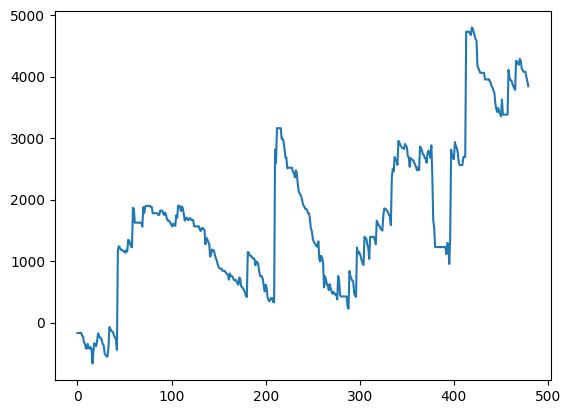

In [94]:
plt.plot(np.cumsum(totoal))

In [95]:
maxholding = 0
winrate = 0
total_trades = 0
for trade in trades:
    maxholding = max(maxholding,len(trade['Entry_Prices']))
    total_trades += len(trade['Entry_Prices'])
    if trade.get('PnL', 0) > 0:
        winrate += len(trade['Entry_Prices'])
winrate = winrate/total_trades
winrate

0.0

In [195]:
result

,datetime,open,high,low,close,volume,ATR,Donchian_High,Donchian_Low,Signal,Position,Trade_Price,Cum_PnL
0,2023-03-02 09:29:00,6389.8,6389.8,6389.8,6389.8,127,NaN,NaN,NaN,0,0,NaN,0.0
1,2023-03-02 09:30:00,6385.2,6391.0,6383.6,6388.6,65462,NaN,NaN,NaN,0,0,NaN,0.0
2,2023-03-02 09:31:00,6388.8,6394.0,6388.0,6393.0,131105,6.700000,NaN,NaN,0,0,NaN,0.0
3,2023-03-02 09:32:00,6393.2,6395.0,6388.6,6392.6,213605,6.550000,NaN,NaN,0,0,NaN,0.0
4,2023-03-02 09:33:00,6392.6,6392.6,6386.2,6388.6,248803,6.475000,NaN,NaN,0,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76266,2024-06-25 14:55:00,4915.2,4920.8,4915.2,4920.6,6174046,4.828639,4925.8,4901.0,0,0,NaN,-2137.6
76267,2024-06-25 14:56:00,4920.8,4921.0,4919.2,4920.2,6097425,3.314319,4925.8,4904.2,0,0,NaN,-2137.6
76268,2024-06-25 14:57:00,4919.8,4924.0,4919.8,4924.0,6184821,3.757160,4925.8,4904.2,0,0,NaN,-2137.6
76269,2024-06-25 14:58:00,4923.8,4925.4,4921.0,4922.8,6003023,4.078580,4925.8,4904.2,0,0,NaN,-2137.6


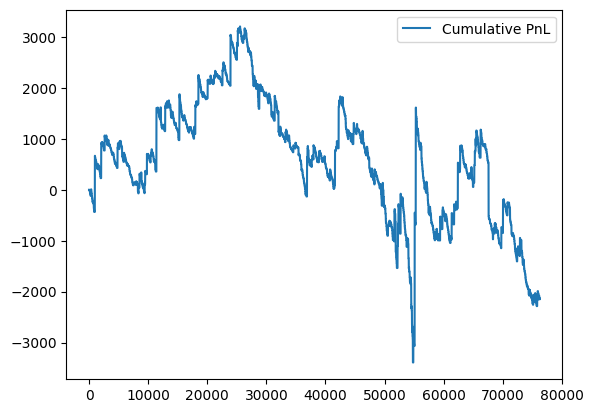

In [196]:
import matplotlib.pyplot as plt
# plt.plot(result['close'], label='Close Price')
# plt.plot(result['Donchian_High'], label='Donchian High')
# plt.plot(result['Donchian_Low'], label='Donchian Low')
plt.plot(result['Cum_PnL'], label='Cumulative PnL')
plt.legend()
plt.show()

In [177]:
dirpath = 'data/IM'
direc = os.listdir(dirpath)
ttpnl = []
wholef = pd.DataFrame()
for file_name in direc:

    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    ff = tick_to_minute(f, freq="min").iloc[1:-4,:]

    result, trades = turtle_backtest(ff, channel_period=2, atr_period=2, add_threshold=0.1, stop_loss_mult=2.4)

    # 输出最后几行回测结果
    # print(result[['open', 'high', 'low', 'close', 'ATR', 'Donchian_High', 'Donchian_Low', 'Signal', 'Position', 'Cum_PnL']].tail())

    day_pnl = 0
    # 输出交易记录
    # print("交易记录：")
    for trade in trades:
        day_pnl += trade.get('PnL', 0)
    ttpnl.append(day_pnl)
    print(day_pnl,file_name)

-192.00000000000182 IM_20230302.csv
-274.99999999999727 IM_20230303.csv
-226.79999999999654 IM_20230306.csv
-238.40000000000236 IM_20230307.csv
-200.80000000000382 IM_20230308.csv
-348.3999999999969 IM_20230309.csv
-189.8000000000011 IM_20230310.csv
-488.199999999998 IM_20230313.csv
-365.99999999999454 IM_20230314.csv
-234.59999999999854 IM_20230315.csv
-257.99999999999363 IM_20230316.csv
-211.39999999999964 IM_20230317.csv
-173.19999999999254 IM_20230320.csv
-377.40000000000236 IM_20230321.csv
-217.20000000000346 IM_20230323.csv
-161.5999999999931 IM_20230324.csv
-172.59999999999945 IM_20230327.csv
-175.00000000000546 IM_20230328.csv
-111.20000000000528 IM_20230329.csv
-671.3999999999978 IM_20230330.csv
-258.0000000000009 IM_20230331.csv
-106.00000000000455 IM_20230403.csv
-177.800000000002 IM_20230404.csv
-147.59999999999854 IM_20230406.csv
-327.39999999999964 IM_20230407.csv
-196.60000000000218 IM_20230410.csv
-63.599999999999454 IM_20230411.csv
-124.79999999999836 IM_20230412.csv
-

In [166]:
local_path = 'E:/ryse/LocalDatabase'
code = 'IM'
# os.makedirs(f'data/{code}', exist_ok=True)
f = pd.read_csv(local_path + '/' + code + '.csv')

f = f[f['Date'] >= 20230302].reset_index(drop=True)

for dt in range(len(f['Date'])):
    date = f['Date'][dt]
    filename = f'{code}_{date}.csv'
    if not os.path.exists(f'data/{code}/{filename}'):
        print(f'Not Processed {filename}')
    if date == 20230829:
        continue

Not Processed IM_20230322.csv
Not Processed IM_20230428.csv
Not Processed IM_20230814.csv
Not Processed IM_20230829.csv
Not Processed IM_20250311.csv
Not Processed IM_20250312.csv
Not Processed IM_20250313.csv
Not Processed IM_20250314.csv
Not Processed IM_20250317.csv


In [77]:
path = 'results/IM'
allfile = pd.DataFrame()
dic = {}
for file in tqdm(os.listdir(path)):
    df = pd.read_csv(os.path.join(path,file))

    if df['pnl'][0] == -1000000:
        continue

    for a in range(len(df)):
        key = tuple(df[['r1','r2','r3']].iloc[a].values)
        if key not in dic:
            dic[key] = df['pnl'][a]
        else:
            dic[key] += df['pnl'][a]
dic

100%|██████████| 223/223 [14:38<00:00,  3.94s/it]


{(0.95, 0.95, 0.95): -1175.6000000000001,
 (0.25, 0.9, 0.2): -247.0000000000174,
 (0.25, 0.9, 0.3): 618.9999999999811,
 (0.25, 0.9, 0.35): 1136.9999999999866,
 (0.25, 0.9, 0.4): 1173.7999999999872,
 (0.25, 0.9, 0.45): 1699.399999999987,
 (0.25, 0.9, 0.5): 1904.5999999999956,
 (0.25, 0.9, 0.55): 2047.999999999997,
 (0.25, 0.9, 0.6): 1135.000000000001,
 (0.25, 0.9, 0.65): 632.7999999999993,
 (0.25, 0.9, 0.7): 816.7999999999972,
 (0.25, 0.9, 0.75): 508.3999999999988,
 (0.25, 0.9, 0.8): 292.4000000000005,
 (0.25, 0.9, 0.85): 1064.399999999995,
 (0.25, 0.9, 0.9): 513.1999999999985,
 (0.25, 0.9, 0.95): 482.1999999999983,
 (0.25, 0.95, 0.0): 251.7999999999904,
 (0.25, 0.9, 0.25): 94.99999999998772,
 (0.25, 0.9, 0.15): -587.6000000000186,
 (0.25, 0.95, 0.1): -13.600000000021993,
 (0.25, 0.9, 0.1): -228.20000000002602,
 (0.25, 0.85, 0.35): 858.5999999999865,
 (0.25, 0.85, 0.4): 1234.9999999999911,
 (0.25, 0.85, 0.45): 1268.9999999999893,
 (0.25, 0.85, 0.5): 1690.5999999999922,
 (0.25, 0.85, 0.5

In [97]:
res = sorted([(k,l) for k,l in dic.items()],key=lambda x:-x[1])
res

[((0.45, 0.6, 0.75), 2686.199999999982),
 ((0.45, 0.6, 0.8), 2580.799999999986),
 ((0.45, 0.6, 0.7), 2522.799999999979),
 ((0.5, 0.6, 0.75), 2500.999999999971),
 ((0.5, 0.6, 0.8), 2395.599999999975),
 ((0.6, 0.6, 0.75), 2360.799999999964),
 ((0.45, 0.5, 0.9), 2360.3999999999814),
 ((0.5, 0.6, 0.7), 2337.5999999999676),
 ((0.05, 0.9, 0.55), 2332.0000000000036),
 ((0.55, 0.6, 0.75), 2331.399999999958),
 ((0.05, 0.85, 0.55), 2328.6000000000013),
 ((0.45, 0.5, 0.85), 2326.7999999999765),
 ((0.45, 0.5, 0.8), 2321.399999999978),
 ((0.1, 0.9, 0.55), 2299.8000000000047),
 ((0.6, 0.6, 0.8), 2255.399999999967),
 ((0.0, 0.85, 0.55), 2242.7999999999997),
 ((0.45, 0.95, 0.5), 2240.1999999999966),
 ((0.1, 0.95, 0.5), 2239.0000000000027),
 ((0.55, 0.6, 0.8), 2225.9999999999627),
 ((0.1, 0.85, 0.55), 2224.6),
 ((0.05, 0.95, 0.5), 2222.200000000002),
 ((0.35, 0.95, 0.5), 2206.199999999998),
 ((0.6, 0.6, 0.7), 2197.3999999999605),
 ((0.4, 0.95, 0.5), 2196.5999999999985),
 ((0.05, 0.9, 0.5), 2188.6000000

In [103]:
res[0]

((0.45, 0.6, 0.75), 2686.199999999982)

In [116]:
apatsl = [[2,0.5,2.4]]
n = 20
totalall = []
totalres = 25

for p in tqdm(res[:1]):
    r = func(apatsl[0],p[0],code = 'IM')
    totoal = []
    for k in r:
        totoal.append(k[6] if k[6] != -1000000 else 0)
    totalall.append(np.cumsum(totoal))

100%|██████████| 1/1 [04:00<00:00, 240.14s/it]


In [133]:
r = np.array(r)
# np.argmax(r[:,6])
# len(r),len(pd.read_csv(f'preds/{code}.csv'))
r[r[:,6] == 641.800]

array([], shape=(0, 8), dtype=float64)

C:\Users\admin\AppData\Local\Temp\ipykernel_23832\1075703020.py:12: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(nav, label=label)


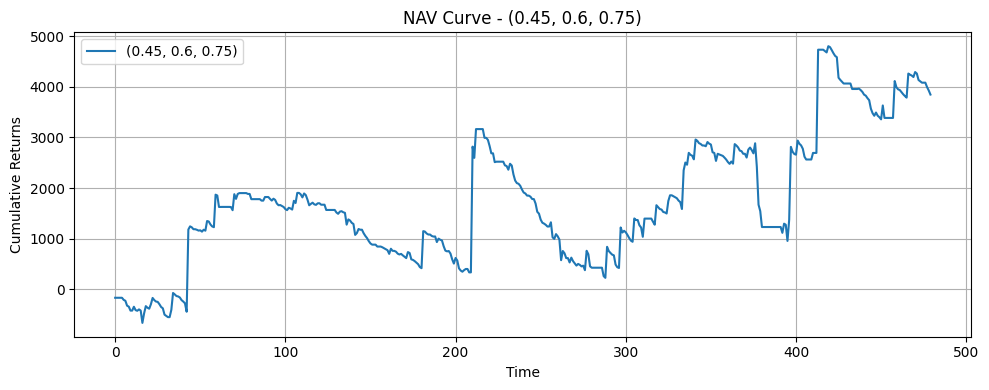

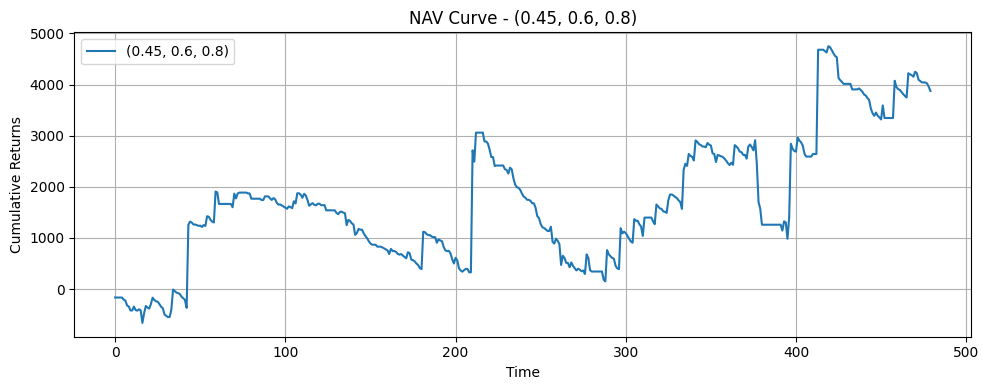

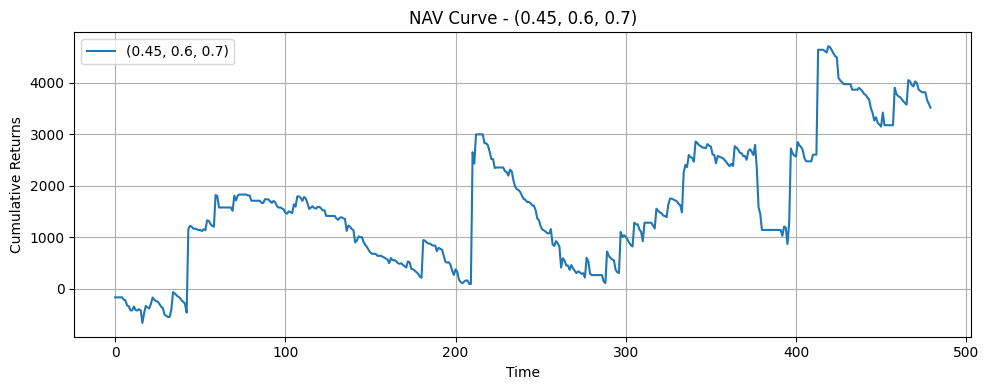

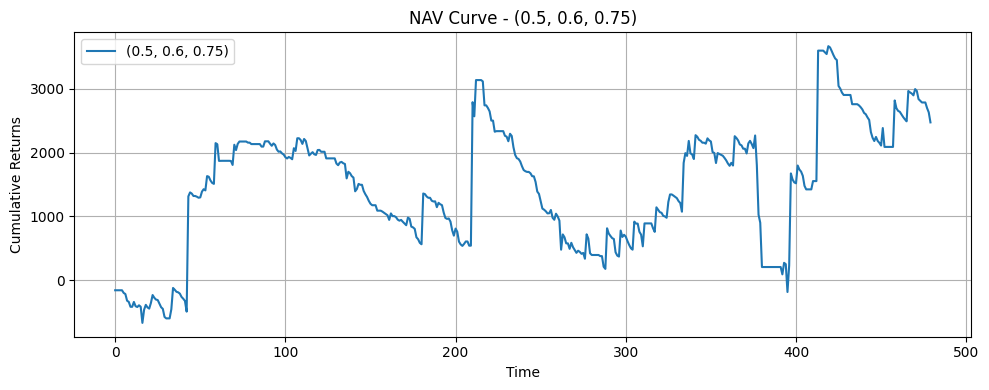

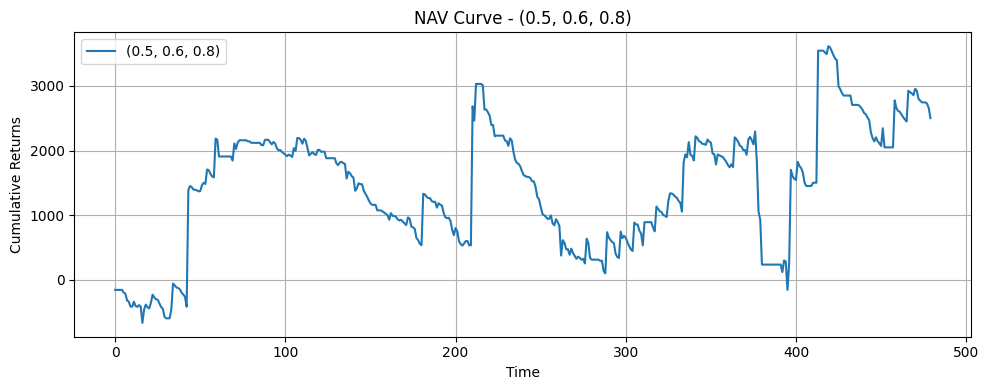

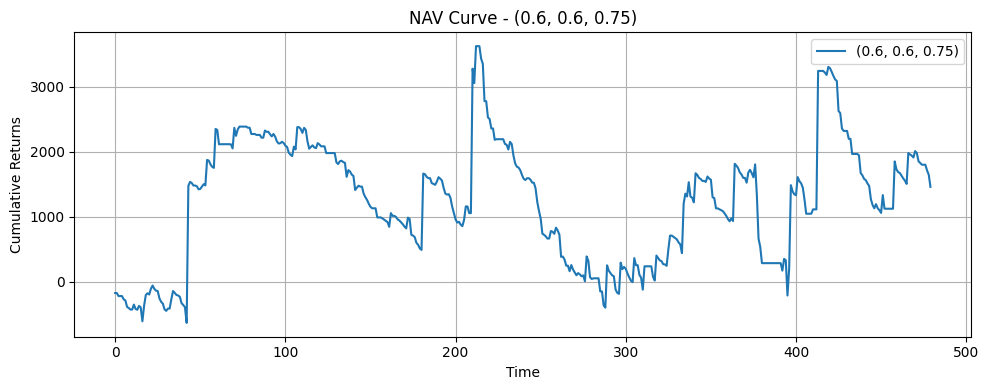

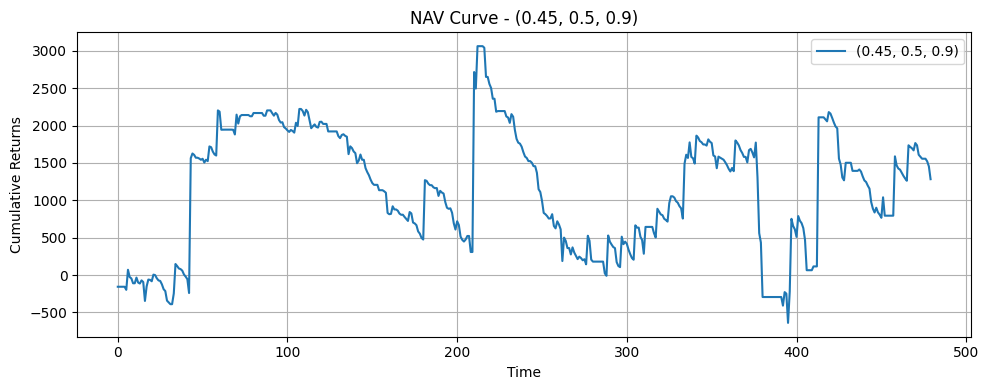

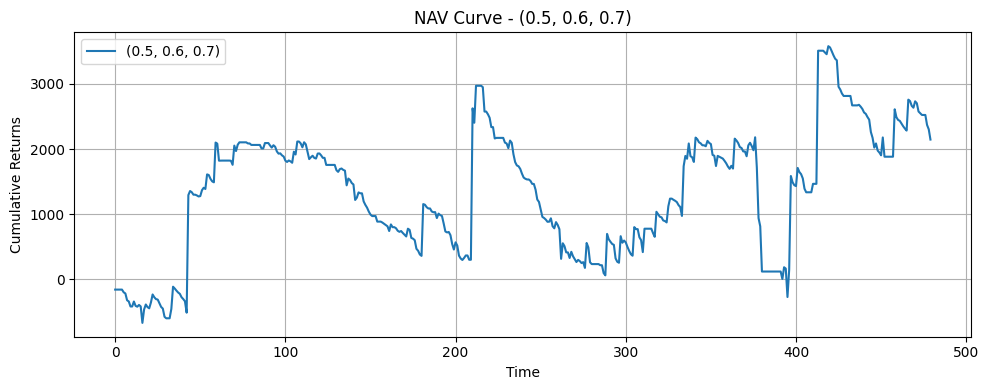

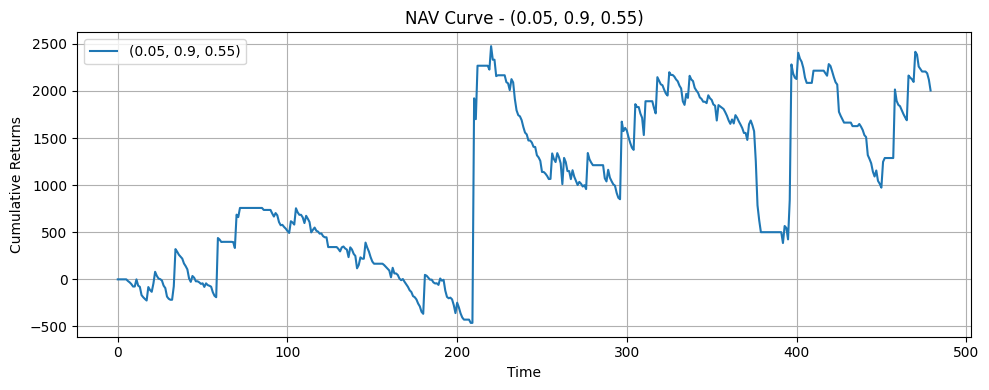

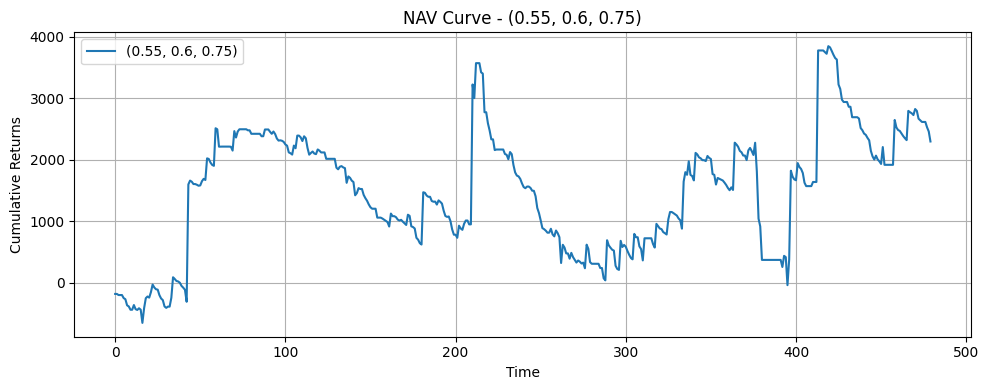

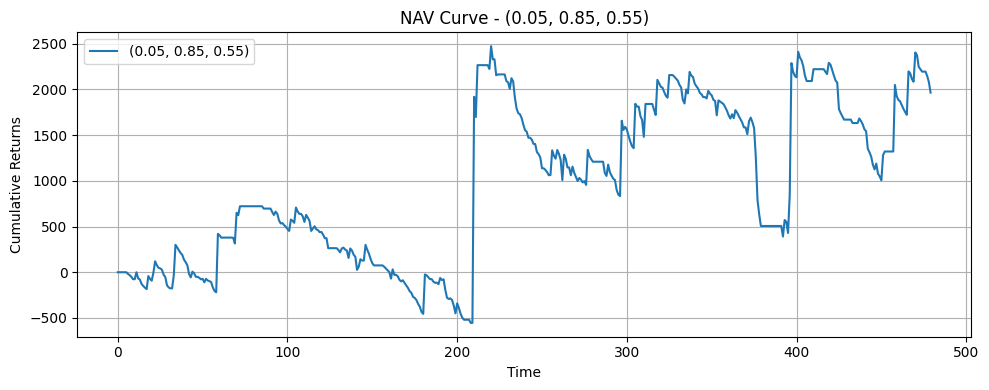

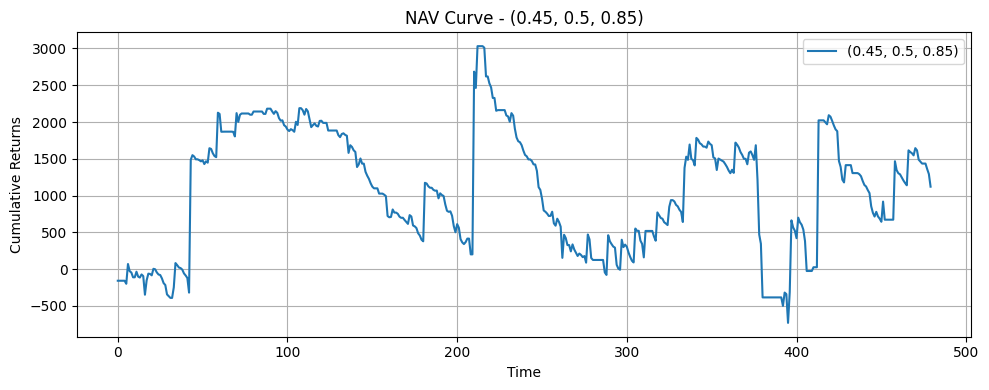

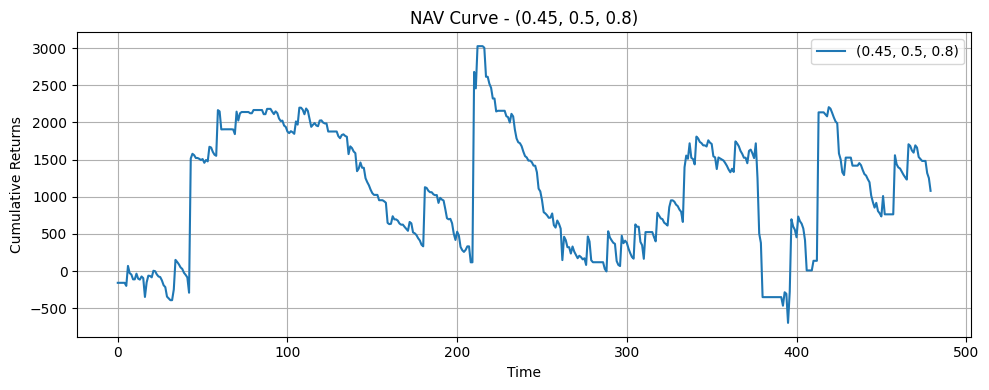

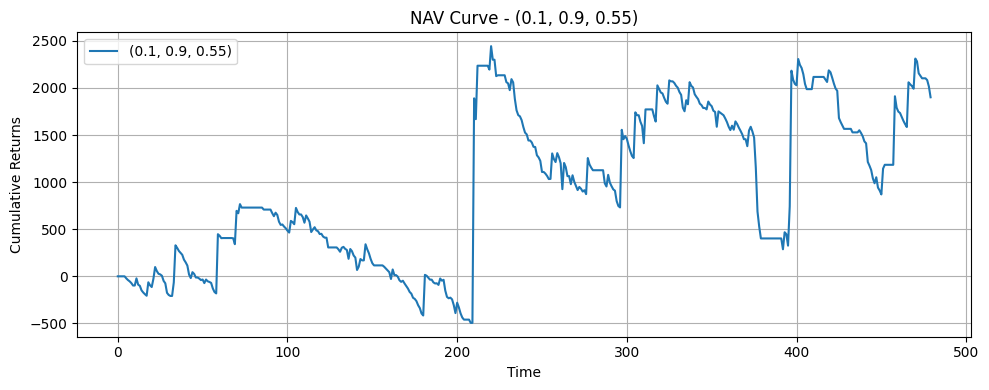

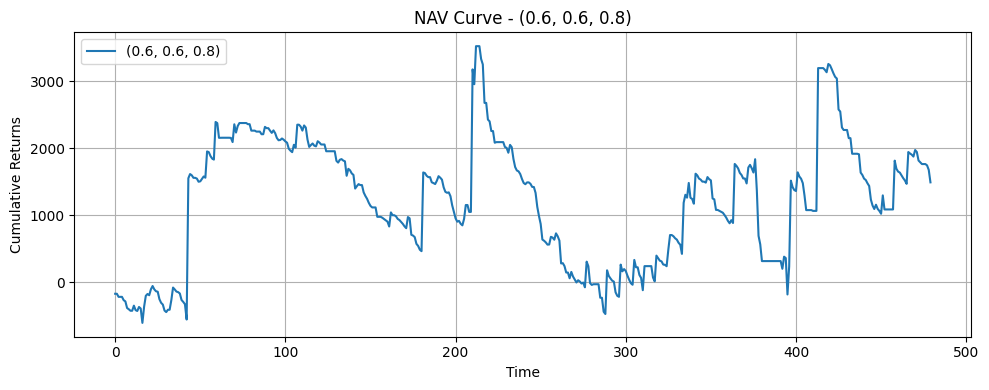

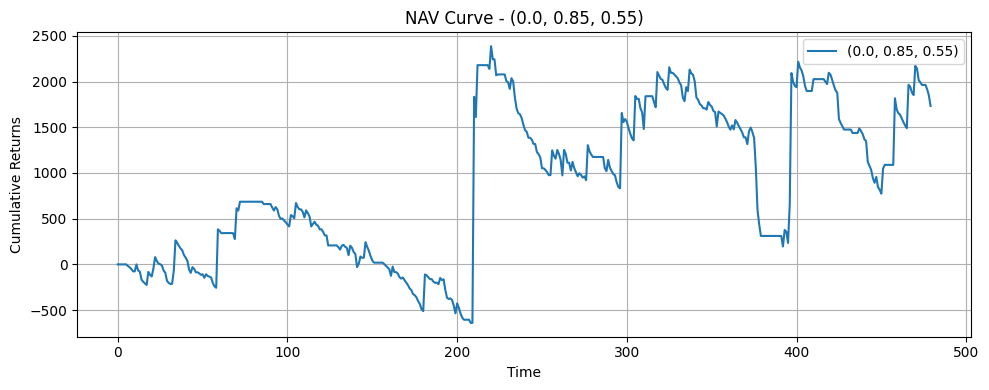

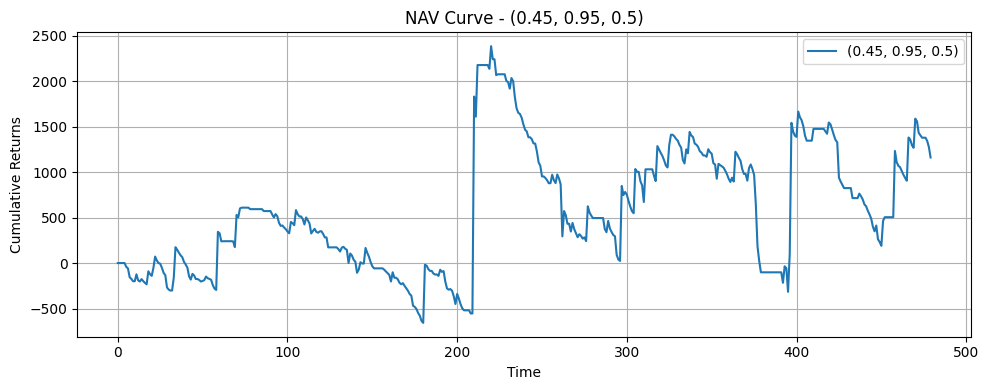

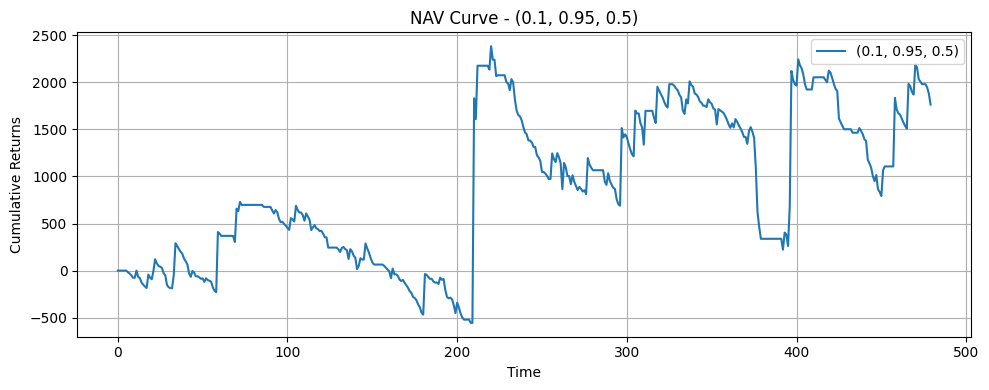

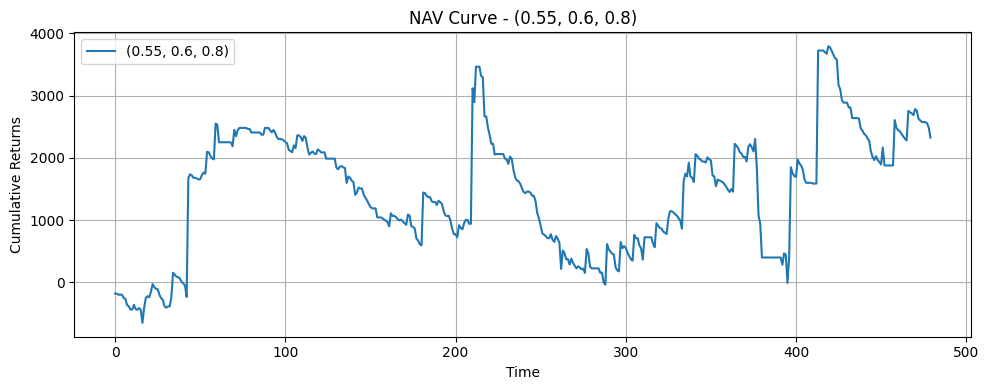

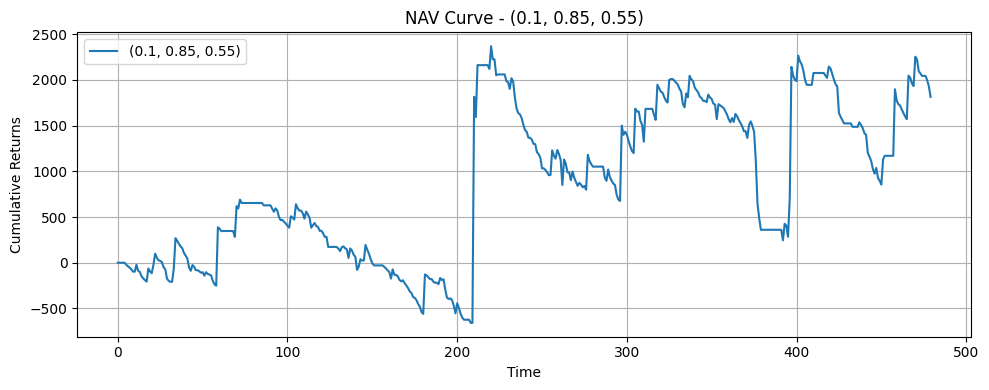

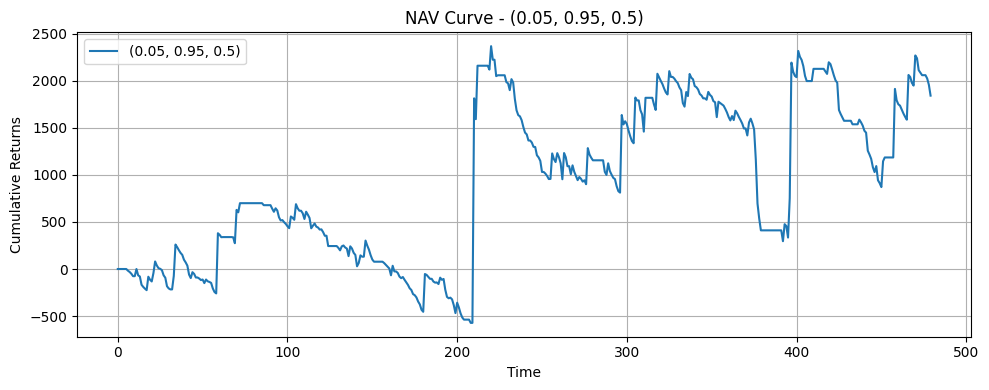

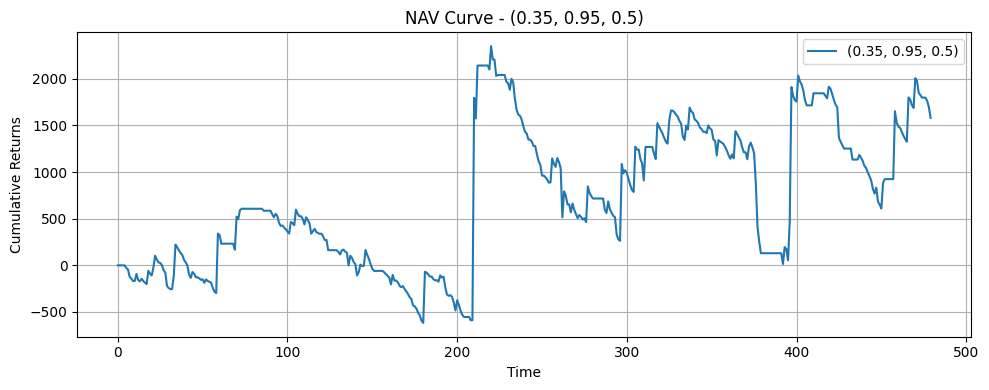

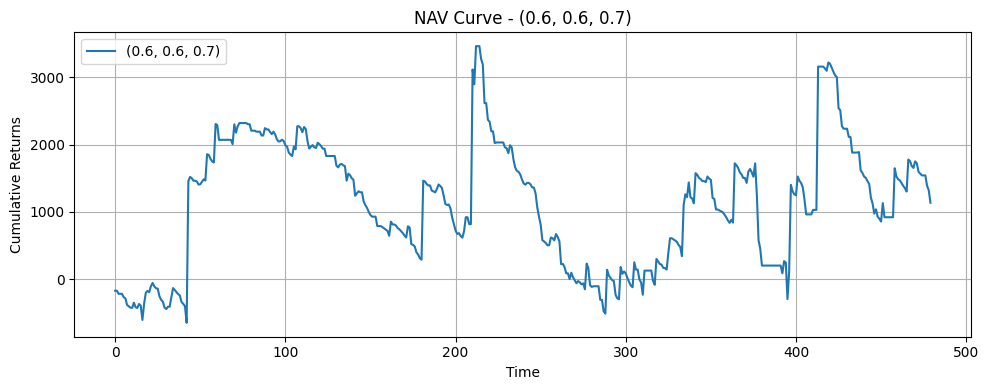

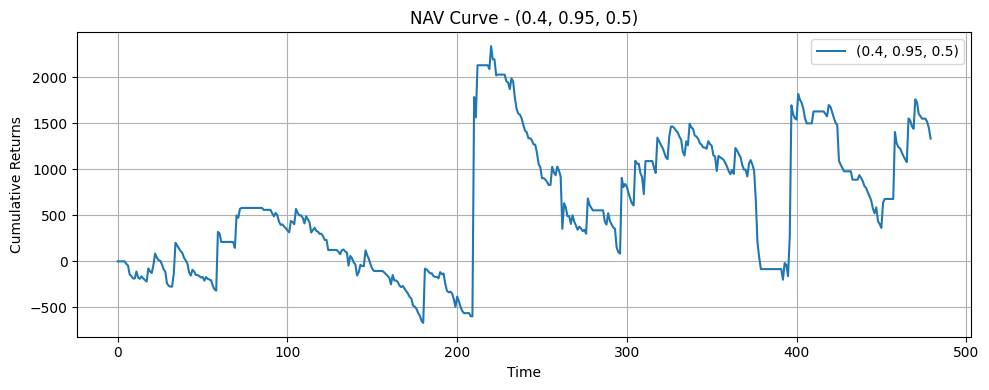

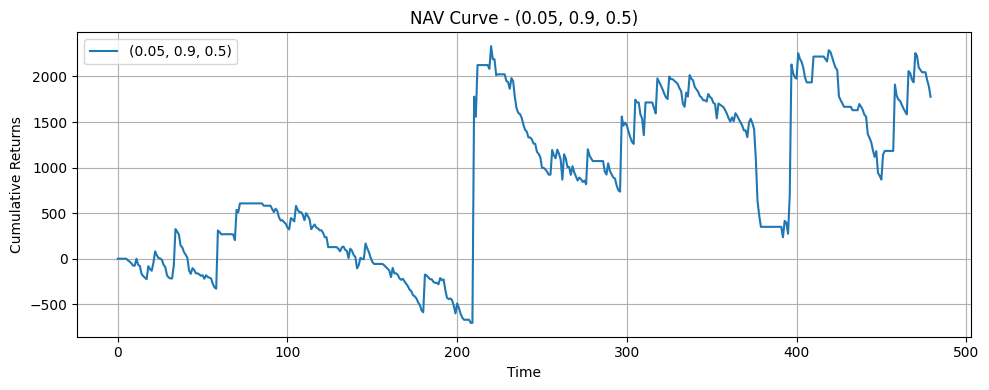

In [105]:
import matplotlib.pyplot as plt

# %matplotlib inline  # 让图像在 Jupyter Notebook 中显示

# 假设你有多个 NAV 的 Series 和对应的名字
nav_list = totalall
labels = [p[0] for p in res[:totalres]]

# 循环单独绘制每一个图表
for nav, label in zip(nav_list, labels):
    plt.figure(figsize=(10, 4))  # 每次新建一个图
    plt.plot(nav, label=label)
    plt.title(f'NAV Curve - {label}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()